<a href="https://colab.research.google.com/github/jidan-fikri/AWAN-App/blob/master/tflite-test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import keras
import tensorflow as tf
import zipfile
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import sklearn
import itertools
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from PIL import Image

In [ ]:
!git clone https://github.com/jidan-fikri/AWAN-App.git

fatal: destination path 'AWAN-App' already exists and is not an empty directory.


In [ ]:
interpreter = tf.lite.Interpreter(model_path='/content/AWAN-App/model/cloudv3.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_inception_v3_input:0
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 3]
type: <class 'numpy.float32'>


In [ ]:
_, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

In [ ]:
def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image

In [ ]:
import os

real_label = []
predicted_label = []
test_path = []

for folder_name in os.listdir('/content/AWAN-App/dataset/test/'):
  if folder_name == 'Heavy_Rain':
    label = 0
  elif folder_name == 'Low_Chance_of_Rain':
    label = 1
  elif folder_name == 'Medium_Rain':
    label = 2
  folder = os.path.join('/content/AWAN-App/dataset/test/', folder_name)
  
  for filename in os.listdir(folder):
    f = os.path.join(folder, filename)
    test_path.append(f)
    real_label.append(label)

In [ ]:
print(len(real_label))
print(len(test_path))

236
236


In [ ]:
def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image

In [ ]:
def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor

In [ ]:
CATEGORIES = ['Heavy_Rain', 'Low_Chance_Rain', 'Medium_Rain']

for idx, (path, rl_label) in enumerate(zip(test_path, real_label)):
  preprocessed_image, original_image = preprocess_image(path, (input_height, input_width))

  set_input_tensor(interpreter, preprocessed_image)
  interpreter.invoke()

  tensor = get_output_tensor(interpreter, 0)
  predicted_label.append(np.argmax(tensor, axis=0))

  real = CATEGORIES[rl_label]
  pred = CATEGORIES[np.argmax(tensor, axis=0)]
  print(f'Index {idx} -- Predicted {pred} \t\t Real Label {real}')

Index 0 -- Predicted Heavy_Rain 		 Real Label Low_Chance_Rain
Index 1 -- Predicted Low_Chance_Rain 		 Real Label Low_Chance_Rain
Index 2 -- Predicted Low_Chance_Rain 		 Real Label Low_Chance_Rain
Index 3 -- Predicted Medium_Rain 		 Real Label Low_Chance_Rain
Index 4 -- Predicted Low_Chance_Rain 		 Real Label Low_Chance_Rain
Index 5 -- Predicted Medium_Rain 		 Real Label Low_Chance_Rain
Index 6 -- Predicted Low_Chance_Rain 		 Real Label Low_Chance_Rain
Index 7 -- Predicted Low_Chance_Rain 		 Real Label Low_Chance_Rain
Index 8 -- Predicted Low_Chance_Rain 		 Real Label Low_Chance_Rain
Index 9 -- Predicted Low_Chance_Rain 		 Real Label Low_Chance_Rain
Index 10 -- Predicted Low_Chance_Rain 		 Real Label Low_Chance_Rain
Index 11 -- Predicted Low_Chance_Rain 		 Real Label Low_Chance_Rain
Index 12 -- Predicted Low_Chance_Rain 		 Real Label Low_Chance_Rain
Index 13 -- Predicted Low_Chance_Rain 		 Real Label Low_Chance_Rain
Index 14 -- Predicted Low_Chance_Rain 		 Real Label Low_Chance_Rain
Ind

                 precision    recall  f1-score   support

     Heavy_Rain       0.79      0.88      0.84        43
Low_Chance_Rain       0.94      0.88      0.91        92
    Medium_Rain       0.89      0.90      0.90       101

       accuracy                           0.89       236
      macro avg       0.88      0.89      0.88       236
   weighted avg       0.89      0.89      0.89       236

Confusion matrix, without normalization
[[38  4  6]
 [ 1 81  4]
 [ 4  7 91]]


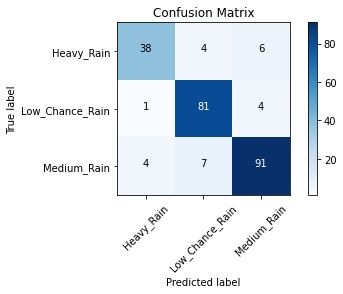

In [ ]:
print(sklearn.metrics.classification_report(real_label, predicted_label, target_names=CATEGORIES))

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(predicted_label, real_label)
cm_plot_labels = CATEGORIES
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
count_miss = 0

for idx, (real, pred, path) in enumerate(zip(real_label, predicted_label, test_path)):
    if real != pred:
      print(f'Index {idx} - Predicted {CATEGORIES[real]} \t Real {CATEGORIES[pred]} \n File : {path} \n')
      count_miss += 1

print(f'Total missclassified: {count_miss}')


Index 0 - Predicted Low_Chance_Rain 	 Real Heavy_Rain 
 File : /content/AWAN-App/dataset/test/Low_Chance_of_Rain/Cs-N041.jpg 

Index 3 - Predicted Low_Chance_Rain 	 Real Medium_Rain 
 File : /content/AWAN-App/dataset/test/Low_Chance_of_Rain/Cs-N086.jpg 

Index 5 - Predicted Low_Chance_Rain 	 Real Medium_Rain 
 File : /content/AWAN-App/dataset/test/Low_Chance_of_Rain/Cs-N254.jpg 

Index 15 - Predicted Low_Chance_Rain 	 Real Medium_Rain 
 File : /content/AWAN-App/dataset/test/Low_Chance_of_Rain/Cs-N080.jpg 

Index 28 - Predicted Low_Chance_Rain 	 Real Medium_Rain 
 File : /content/AWAN-App/dataset/test/Low_Chance_of_Rain/Ci-N129.jpg 

Index 37 - Predicted Low_Chance_Rain 	 Real Heavy_Rain 
 File : /content/AWAN-App/dataset/test/Low_Chance_of_Rain/Cs-N005.jpg 

Index 46 - Predicted Low_Chance_Rain 	 Real Heavy_Rain 
 File : /content/AWAN-App/dataset/test/Low_Chance_of_Rain/Ci-N097.jpg 

Index 67 - Predicted Low_Chance_Rain 	 Real Heavy_Rain 
 File : /content/AWAN-App/dataset/test/Low_Chan